In [14]:
import argparse
import csv
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

# ── Penn State official colour palette ────────────────────────────────────
BG_COLOR       = "#001E44"  # Nittany Navy
PITCH_COLOR    = "#1E407C"  # Beaver Blue for pitch surface
LINE_COLOR     = "#3A5A9C"  # slightly lighter Beaver Blue for pitch lines
ACCENT_COLOR   = "#FFFFFF"  # White Out
ARROW_COLOR    = "#FFFFFF"  # White Out
RECEIVER_COLOR = "#FFFFFF"  # White Out
TEXT_COLOR     = "#FFFFFF"  # White Out
DIM_COLOR      = "#7A9ACC"  # lightened Beaver Blue for secondary text

# ── Pitch dimensions (mplsoccer standard) ──────────────────────────────────
PITCH_LENGTH = 105
PITCH_WIDTH  = 68


def draw_pitch(ax):
    """Draw a full-size football pitch on ax, Athletic dark style."""
    ax.set_facecolor(PITCH_COLOR)

    lw = 1.2
    lc = LINE_COLOR

    def line(x0, y0, x1, y1):
        ax.plot([x0, x1], [y0, y1], color=lc, linewidth=lw, zorder=1)

    def circle(cx, cy, r, **kwargs):
        c = plt.Circle((cx, cy), r, fill=False, color=lc, linewidth=lw, zorder=1, **kwargs)
        ax.add_patch(c)

    # Outer boundary
    rect = mpatches.Rectangle((0, 0), PITCH_LENGTH, PITCH_WIDTH,
                               linewidth=lw, edgecolor=lc, facecolor="none", zorder=1)
    ax.add_patch(rect)

    # Halfway line
    line(PITCH_LENGTH / 2, 0, PITCH_LENGTH / 2, PITCH_WIDTH)

    # Centre circle
    circle(PITCH_LENGTH / 2, PITCH_WIDTH / 2, 9.15)
    ax.plot(PITCH_LENGTH / 2, PITCH_WIDTH / 2, "o", color=lc, markersize=2, zorder=1)

    # Penalty areas
    for x_base, sign in [(0, 1), (PITCH_LENGTH, -1)]:
        pa_w = 40.32
        pa_d = 16.5
        pa_y = (PITCH_WIDTH - pa_w) / 2
        rect_pa = mpatches.Rectangle(
            (x_base + sign * 0, pa_y) if sign == 1 else (x_base - pa_d, pa_y),
            pa_d * sign if sign == 1 else pa_d,
            pa_w,
            linewidth=lw, edgecolor=lc, facecolor="none", zorder=1
        )
        ax.add_patch(rect_pa)

        ga_w = 18.32
        ga_d = 5.5
        ga_y = (PITCH_WIDTH - ga_w) / 2
        rect_ga = mpatches.Rectangle(
            (x_base, ga_y) if sign == 1 else (x_base - ga_d, ga_y),
            ga_d * sign if sign == 1 else ga_d,
            ga_w,
            linewidth=lw, edgecolor=lc, facecolor="none", zorder=1
        )
        ax.add_patch(rect_ga)

        # Penalty spot
        pen_x = x_base + sign * 11 if sign == 1 else x_base + sign * 11
        ax.plot(pen_x, PITCH_WIDTH / 2, "o", color=lc, markersize=2, zorder=1)

        # Penalty arc
        theta = np.linspace(0, 2 * np.pi, 300)
        arc_x = pen_x + 9.15 * np.cos(theta)
        arc_y = PITCH_WIDTH / 2 + 9.15 * np.sin(theta)
        mask = arc_x > pa_d if sign == 1 else arc_x < (PITCH_LENGTH - pa_d)
        ax.plot(arc_x[mask], arc_y[mask], color=lc, linewidth=lw, zorder=1)

    ax.set_xlim(-2, PITCH_LENGTH + 2)
    ax.set_ylim(-2, PITCH_WIDTH + 2)
    ax.set_aspect("equal")
    ax.axis("off")


def scale_coords(x, y):
    """
    Convert from 0-100 normalised coordinate space to standard pitch dimensions
    (105 m long x 68 m wide). The source data uses a 100x100 grid where:
        x: 0 = own goal line, 100 = opponent goal line
        y: 0 = left touchline, 100 = right touchline
    """
    return x / 100.0 * PITCH_LENGTH, (100.0 - y) / 100.0 * PITCH_WIDTH


def load_playups(csv_path):
    """
    Load playup events from CSV.
    Coordinates in the CSV are 0-100 normalised and are scaled to 105x68.
    Returns list of dicts with keys:
        player, team, sx, sy, ex, ey  (all in 105x68 pitch space)
    Only rows where Event Type == "Playup" are used as the primary event.
    """
    playups = []
    with open(csv_path, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["Event Type"].strip().lower() == "playup":
                try:
                    sx, sy = scale_coords(float(row["Start X"]), float(row["Start Y"]))
                    ex, ey = scale_coords(float(row["End X"]),   float(row["End Y"]))
                    playups.append({
                        "player": row["Player Name"].strip(),
                        "team":   row["Player Team"].strip(),
                        "sx": sx, "sy": sy,
                        "ex": ex, "ey": ey,
                        "_raw_key": (
                            round(float(row["Start X"]), 2),
                            round(float(row["Start Y"]), 2),
                            round(float(row["End X"]),   2),
                            round(float(row["End Y"]),   2),
                        ),
                    })
                except (ValueError, KeyError):
                    pass
    return playups


def load_receivers(csv_path):
    """Load Playup Received events keyed by raw 100x100 coordinates."""
    received = {}
    with open(csv_path, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["Event Type"].strip().lower() == "playup received":
                try:
                    key = (
                        round(float(row["Start X"]), 2),
                        round(float(row["Start Y"]), 2),
                        round(float(row["End X"]),   2),
                        round(float(row["End Y"]),   2),
                    )
                    received[key] = row["Player Name"].strip()
                except (ValueError, KeyError):
                    pass
    return received


def straight_arrow(ax, x0, y0, x1, y1, color, lw=2.0, alpha=0.9):
    """Draw a straight arrow from (x0,y0) to (x1,y1)."""
    arrow = FancyArrowPatch(
        (x0, y0), (x1, y1),
        arrowstyle="-|>",
        mutation_scale=12,
        color=color,
        linewidth=lw,
        alpha=alpha,
        connectionstyle="arc3,rad=0",
        zorder=5,
        path_effects=[pe.Stroke(linewidth=lw + 1.5, foreground=BG_COLOR), pe.Normal()],
    )
    ax.add_patch(arrow)


def player_stats(playups):
    """Count playups per player."""
    counts = defaultdict(int)
    for p in playups:
        counts[p["player"]] += 1
    return counts


def make_playup_map(csv_path: str, output_path: str = None):
    csv_path = Path(csv_path)
    playups  = load_playups(csv_path)
    received = load_receivers(csv_path)

    if not playups:
        print("No 'Playup' events found in CSV.", file=sys.stderr)
        sys.exit(1)

    # ── Figure setup ────────────────────────────────────────────────────────
    fig = plt.figure(figsize=(14, 10), facecolor=BG_COLOR)

    # Title area (top strip)
    ax_title = fig.add_axes([0.0, 0.88, 1.0, 0.12])
    ax_title.set_facecolor(BG_COLOR)
    ax_title.axis("off")

    # Pitch area
    ax = fig.add_axes([0.04, 0.10, 0.92, 0.76])
    ax.set_facecolor(BG_COLOR)
    draw_pitch(ax)

    # ── Per-player colour mapping ────────────────────────────────────────────
    players  = sorted(set(p["player"] for p in playups))
    palette  = ["#FFFFFF", "#7A9ACC", "#B0C8E8", "#4A7AB5", "#D0E0F0"]
    p_colors = {name: palette[i % len(palette)] for i, name in enumerate(players)}

    counts   = player_stats(playups)

    # ── Draw arrows ──────────────────────────────────────────────────────────
    plotted_ends = []  # to space out labels

    for pu in playups:
        sx, sy, ex, ey = pu["sx"], pu["sy"], pu["ex"], pu["ey"]
        color = p_colors[pu["player"]]

        # Origin dot
        ax.scatter(sx, sy, s=60, color=color, zorder=6, alpha=0.95,
                   edgecolors=BG_COLOR, linewidths=1)

        # Arrow
        straight_arrow(ax, sx, sy, ex, ey, color=color, lw=1.8)

        # Receiver dot
        ax.scatter(ex, ey, s=80, color=RECEIVER_COLOR, marker="D", zorder=7,
                   edgecolors=BG_COLOR, linewidths=1, alpha=0.9)

        # Receiver name label (offset to avoid overlap)
        rec_name = received.get(pu["_raw_key"], "")
        if rec_name:
            ax.text(ex + 1.5, ey + 1.5, rec_name, color=RECEIVER_COLOR,
                    fontsize=6.5, fontweight="bold", zorder=8,
                    path_effects=[pe.Stroke(linewidth=2, foreground=BG_COLOR),
                                  pe.Normal()])

    # ── Player origin labels ─────────────────────────────────────────────────
    for pu in playups:
        ax.text(pu["sx"] - 1.5, pu["sy"] - 2, pu["player"],
                color=p_colors[pu["player"]], fontsize=6.5, fontweight="bold",
                ha="right", zorder=8,
                path_effects=[pe.Stroke(linewidth=2, foreground=BG_COLOR),
                               pe.Normal()])

    # ── Direction indicator ──────────────────────────────────────────────────
    ax.annotate("", xy=(PITCH_LENGTH - 1, -1.5), xytext=(PITCH_LENGTH - 15, -1.5),
                arrowprops=dict(arrowstyle="<|-", color=DIM_COLOR, lw=1.2),
                annotation_clip=False)
    ax.text(PITCH_LENGTH - 8, -4, "Attack", color=DIM_COLOR,
            fontsize=7, ha="center", clip_on=False)

    # ── Legend ───────────────────────────────────────────────────────────────
    legend_elements = [
        Line2D([0], [0], marker="o", color="w", markerfacecolor=p_colors[p],
               markersize=7, label=f"{p} ({counts[p]})", linewidth=0)
        for p in players
    ]
    legend_elements += [
        Line2D([0], [0], marker="D", color="w", markerfacecolor=RECEIVER_COLOR,
               markersize=7, label="Playup Receiver", linewidth=0),
    ]
    legend = ax.legend(
        handles=legend_elements,
        loc="lower left",
        bbox_to_anchor=(0.0, -0.03), # Adjusted from -0.12 to -0.03
        ncol=min(len(legend_elements), 4),
        frameon=False,
        fontsize=8,
        labelcolor=TEXT_COLOR,
    )

    # ── Titles ────────────────────────────────────────────────────────────────
    date_str = csv_path.stem.replace("touchline-events-", "").replace("-", " ").title()
    team_ids = list(set(p["team"] for p in playups))
    team_str = f"Team {', '.join(team_ids)}" if team_ids else ""

    ax_title.text(0.04, 0.75, "PLAYUP MAP", color=TEXT_COLOR, # Changed title to Davy Leavey
                  fontsize=22, fontweight="bold", va="top", transform=ax_title.transAxes)
    ax_title.text(0.04, 0.30, f"{team_str}  ·  {date_str}", # Subtitle now includes team and date
                  color=DIM_COLOR, fontsize=11, va="top", transform=ax_title.transAxes)
    ax_title.text(0.96, 0.75,
                  "Each arrow shows a player breaking the midfield\nor defensive line with a pass.",
                  color=DIM_COLOR, fontsize=8, va="top", ha="right",
                  transform=ax_title.transAxes)

    # Accent bar under title
    ax_title.axhline(0.05, color=ACCENT_COLOR, linewidth=2.5,
                     xmin=0.03, xmax=0.97)

    # ── Save / show ───────────────────────────────────────────────────────────
    if output_path is None:
        output_path = csv_path.stem + "_playup_map.png"

    plt.savefig(output_path, dpi=180, bbox_inches="tight",
                facecolor=BG_COLOR, edgecolor="none")
    print(f"Saved → {output_path}")
    return output_path

Saved → georgetownSpring_playup_map.png


'georgetownSpring_playup_map.png'

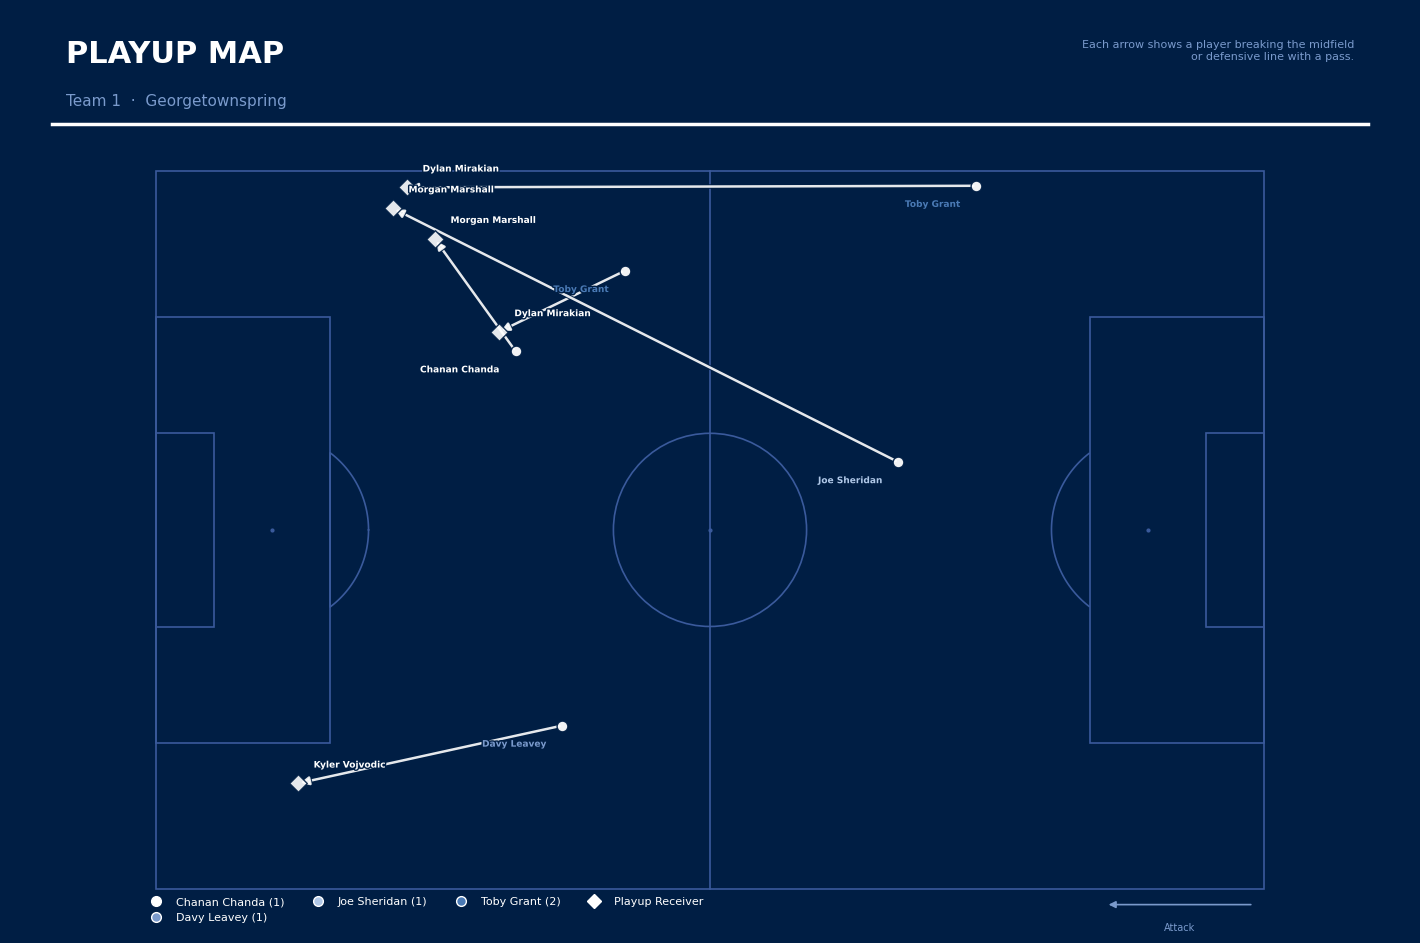

In [13]:
make_playup_map('/content/georgetownSpring.csv')